<a href="https://colab.research.google.com/github/Clarkdrengen/PML_2023/blob/main/PML_Part_b_Team_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [170]:
!pip3 install pyro-ppl
!pip3 install -Uqq ipdb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [171]:
import arviz

import os
import ipdb

import torch
import numpy as np

import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.infer.mcmc as HMC
import pyro.distributions as dist

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import datasets
from sklearn import model_selection

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo

In [172]:
pyro.set_rng_seed(1)
n = 1000
X = torch.linspace(-1.0, 1.0, n) 

def func(X):
  return np.sin(20*X) + 2*np.cos(14*X) - 2*np.sin(6*X)

In [173]:
x = torch.linspace(-1.0, 1.0, 5)
y = func(x)

In [174]:
## normalize data to zero mean
#mean, var = torch.mean(y), torch.var(y)
#y  = (y-mean)/var

In [175]:
kernel = gp.kernels.RBF(input_dim=1)
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
gpr = gp.models.GPRegression(x, y, kernel)

In [237]:
hmc_kernel=pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=1000, num_chains=5, warmup_steps=1000)
mcmc.run()


/usr/local/lib/python3.8/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=5 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Warmup:   0%|          | 0/2000 [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/2000 [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1)

In [234]:
samples = mcmc.get_samples()
posterior_ls = mcmc.get_samples()["kernel.lengthscale"]
posterior_vs = mcmc.get_samples()["kernel.variance"]

In [241]:
posterior_ls[1000]

tensor(1.2409)

In [178]:
az_data = arviz.from_pyro(posterior=mcmc)
summary = arviz.summary(az_data)
summary

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel.lengthscale,0.606,0.724,0.008,1.679,0.013,0.009,3395.0,3294.0,1.0
kernel.variance,2.250,3.107,0.008,6.873,0.053,0.038,3243.0,2523.0,1.0


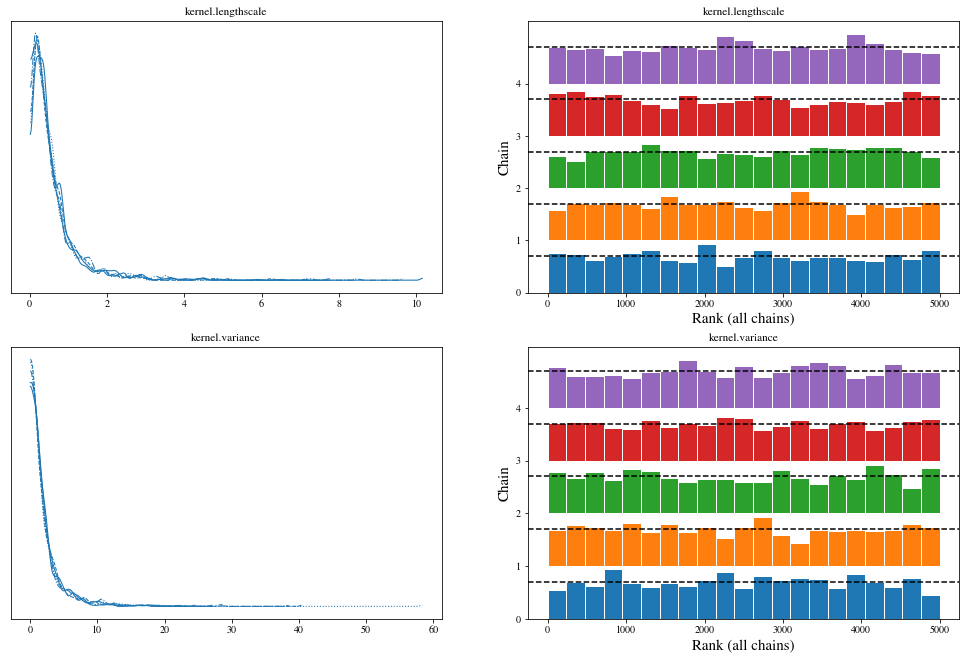

In [179]:
from numpy.core.fromnumeric import size
axes = arviz.plot_trace(az_data, figsize=(17, 11),compact = True, kind="rank_bars")
#fig = axes.ravel()[0].figure
#fig.savefig("rank_bar_plot.png", dpi=300)


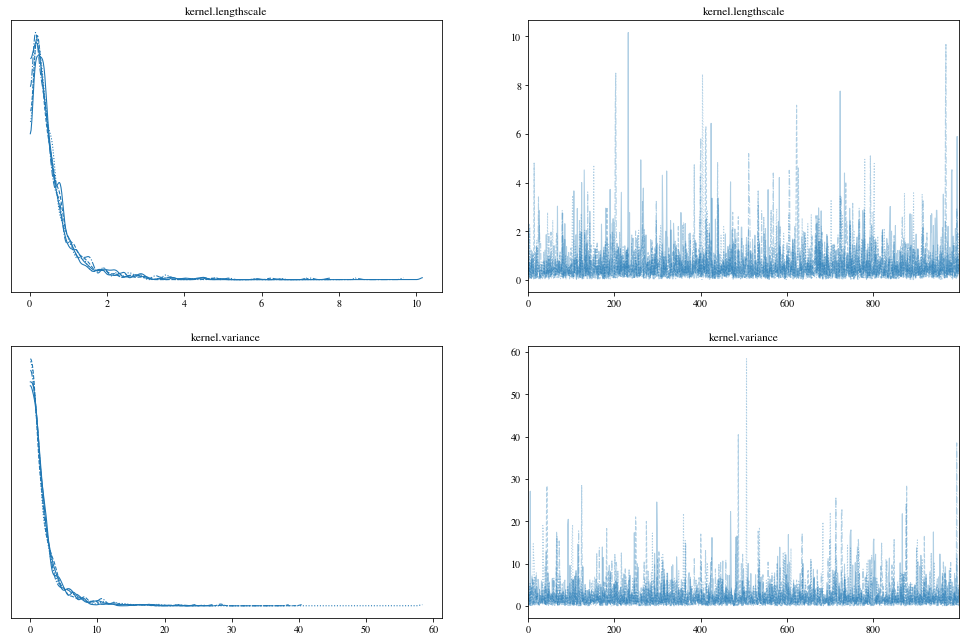

In [180]:
axes = arviz.plot_trace(az_data, figsize=(17, 11))
fig = axes.ravel()[0].figure
fig.savefig("arviz_generic.png", dpi=300)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c5a5bebb0>,
      dtype=object)

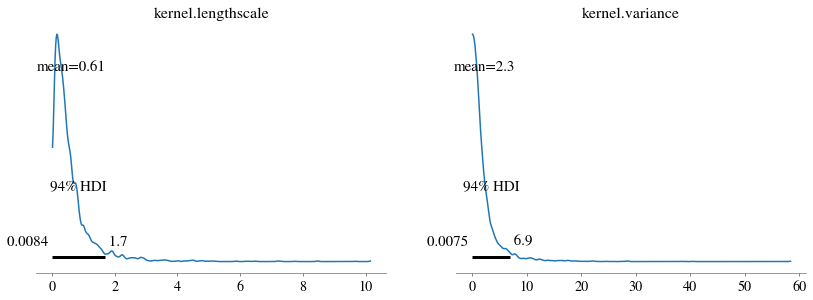

In [181]:
arviz.plot_posterior(az_data)

# Create log/log scatter plot of 500 samples from the posterior $p(θ|\mathcal{D})$

In [182]:
import random
idx = random.sample(range(1000), 500)
post_len = []
for i in idx:
  post_len.append(posterior_ls[i])

post_var = []
for i in idx:
  post_var.append(posterior_vs[i])

post_len = pd.DataFrame(post_len)
post_var = pd.DataFrame(post_var)
df = pd.concat([post_len.reset_index(drop=True), post_var], axis=1)
df.columns = ['length_scale', 'variance']

In [183]:
mpl.rcParams.update(mpl.rcParamsDefault) #clear mlp params
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['text.usetex'] = True #enable Tex

Text(0.5, 1.0, '500 samples from the posterior')

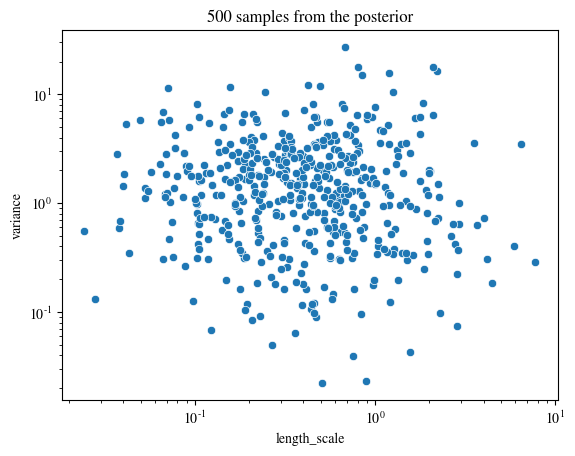

In [184]:
sns.scatterplot(data=df, x="length_scale", y="variance")
plt.xscale('log')
plt.yscale('log')
plt.title('500 samples from the posterior')
#plt.axvline(df['length_scale'].median(), ls = '--')
#plt.axhline(df['variance'].median(), ls = '--')



Use the obtained MCMC samples from the posterior to obtain estimates of mean $m(x^{∗})$ and variance $v(x^{∗})$ of $p(y^{∗}|x^{∗}, D)$ at a point $x^{∗} ∈ [−1, 1]$

See https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes.ipynb#scrollTo=IYJ36MT_NLwR

In [185]:
posterior_kernel_ls = mcmc.get_samples()["kernel.lengthscale"]
posterior_kernel_var = mcmc.get_samples()["kernel.variance"]

In [186]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()
    plt.xlabel('input, $x$')
    plt.ylabel('output, $f(x)$')

In [187]:
## create RBF kernel function
import numpy as np

def kernel(X1, X2, l=torch.mean(posterior_kernel_ls).item(), sigma_f=torch.mean(posterior_kernel_var).item()):
    """
    The Gaussian kernel
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

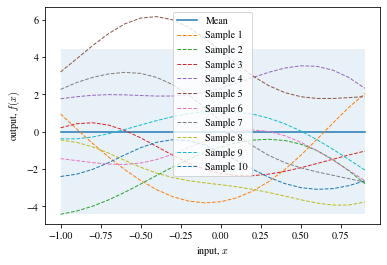

In [229]:
%matplotlib inline

# Finite number of points
X = np.arange(-1, 1.0, 0.1).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 10)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu, cov, X, samples=samples)

In [225]:
cov.shape

(21, 21)

In [189]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=torch.mean(posterior_kernel_ls).item(), 
              sigma_f=torch.mean(posterior_kernel_var).item(), sigma_y=1e-4):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [206]:
mu_s.shape

(21, 1)

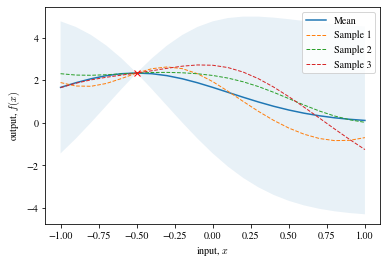

In [191]:
# Noise free training data
#X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
#X_train = np.linspace(-1.0, 1.0, 5).reshape(-1, 1)
#X_train = x.numpy().reshape(-1, 1)
X_train=np.array([-.5]).reshape(-1, 1)
Y_train = func(X_train)

#ipdb.set_trace(context=6)
# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

#B.2 Build a Bayesian Optimization loop to find a local optimum of $f$ 

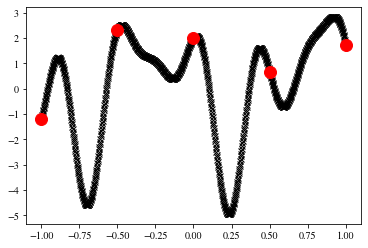

In [198]:
n = 1000
X = torch.linspace(-1.0, 1.0, n) 

def func(X):
  return np.sin(20*X) + 2*np.cos(14*X) - 2*np.sin(6*X)

y = func(X)

xs = torch.linspace(-1.0, 1.0, 5)
ys = func(xs)
ys

plt.plot(X.numpy(), y.numpy(), "kx")
plt.plot(xs.numpy(), ys.numpy(), linestyle="",marker="o", color='red', markersize=12)

In [202]:
# prep
x_new = x.tolist() ## convert tensor to list
y_new = []  
for x in D:
  def res(x): return func(x)
  y_new.append(res(x))

dictionary = dict(zip(x_new, y_new))

In [211]:
len(x_new)

5

In [231]:
# Gather data
D = []
for i in range(len(x_new)):
  D.append([x_new[i], y_new[i]])

In [233]:
# subset HMC theta values
samples.shape


(10, 20)

In [168]:

#Sample f∗ ∼ p(f∗|X∗,D)

#p = arg min_(i) f_{i}{∗}

#append (x∗p,f(x∗p)) to the dataset D

In [169]:
func_vals

[-1.1983018107098122,
 2.3340656356957132,
 2.0,
 0.681543381677505,
 1.7452506835411465]